## *Seminar 11: Stochastic Volatility Inspired model (SVI)*

## 1. SVI model

No SDE, just volatility smile parametrization.

Notation:
- $T$ — time to expiration,
- $F_0$ — current forward price,
- $K$ — strike price,
- $x = \ln(K/F_0)$ — log-moneyness, 
- $\hat\sigma$ — implied volatility,
- $ w = T\hat\sigma^2$ — total variance.

Black's formula in this notation:
$$
C = e^{-rT}\bigl(F_0\Phi(d_1) - K\Phi(d_2)\bigr), \qquad
d_1 = -\frac{x}{\sqrt{ w}} + \frac{\sqrt{ w}}{2},\quad
d_2 = -\frac{x}{\sqrt{ w}} - \frac{\sqrt{ w}}{2}.
$$

### 1.1 Raw parametrization

$$
w(x) = a + b\left(\rho(x-m) + \sqrt{(x-m)^2 + \sigma^2}\right)
$$

- $a$ and $m$ — vertical and horizontal shift,
- $b$ — angle between asymptotes as $x\to\pm\infty$:
$$
w(x) \sim a - b(1 -\rho) (x - m)\ \text{as}\ x\to-\infty, \\
w(x)\sim a + b(1 +\rho) (x - m)\ \text{as}\ x\to+\infty,
$$
- $\sigma$ — convexity,
- $\rho$ — skew.

### 1.2 Natural parametrization

Parameters: $\Delta,\mu,\rho,\omega,\zeta$ ($\omega\ge 0$, $\Delta,\mu\in R$, $|\rho|<1$, $\zeta>0$)

$$
w(x) = \Delta + \frac\omega2 \left(1 + \zeta\rho(x-\mu) +
\sqrt{(\zeta(x-\mu)+\rho)^2 + 1-\rho^2} \right).
$$

### 1.3 Jump-wings parametrization

More stable for different expiration times.

$$
\begin{aligned}
&v = \frac{a+b(-\rho m+\sqrt{m^2+\sigma^2})}{T},\\
&\psi = \frac{b}{2\sqrt{vT}} \left( -\frac{m}{\sqrt{m^2+\sigma^2}} +\rho 
\right),\\
&p = \frac{b(1-\rho)}{\sqrt{vT}},\\
&c = \frac{b(1+\rho)}{\sqrt{vT}},\\
&\tilde v = \frac 1T (a+b\sigma\sqrt{1-\rho^2}).
\end{aligned}
$$

Interpretation:

- $v = \hat\sigma^2(0)$ — ATM variance;
- $\psi = \partial_x \sqrt{w(x)} \mid_{x=0} = \sqrt T\partial_x \hat\sigma(x) \mid_{x=0}$ — ATM skew;
- $p$ — asymptote slope absolute value $\frac{w(x)}{\hat\sigma(0)\sqrt T}$ as $x\to-\infty$, i.e. $p=-\lim\limits_{x\to-\infty} \frac{w(x)}{x\hat\sigma(0)\sqrt{T}}$ (left wing slope);
- $c$ — right wing slope;
- $\tilde v = \min_{x} \hat\sigma^2(x)$ — implied variance minimum.

In [1]:
from dataclasses import dataclass, astuple
from copy import deepcopy
from typing import Callable, Union
import math
import json

import numpy as np
import numpy.typing as npt
from scipy import optimize
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from ipywidgets import widgets, interact

In [2]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0
    
@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]] = None
    
    def __post_init__(self):
        assert self.is_call is not None
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __post_init__(self):
        self.is_call = True
        
class PutStockOption(StockOption):
    def __post_init__(self):
        self.is_call = False

In [3]:
@dataclass
class SVIParams:
    a: float
    b: float
    rho: float
    m: float
    sigma: float

    def to_natural(self) -> tuple[float, float, float, float, float]:
        """Returns parameters of the natural parametrization.

        The natural parametrization is:
          `w(x) = delta + omega/2 * (1 + zeta*rho*(x-mu)
                + sqrt((zeta*(x-mu) + rho)**2 + 1 - rho**2)`

        Returns:
          Tuple `(delta, mu, rho, omega, zeta)`.
        """
        omega = 2 * self.b * self.sigma / np.sqrt(1 - self.rho**2)
        delta = self.a - 0.5 * omega * (1 - self.rho**2)
        mu = self.m + self.rho * self.sigma / np.sqrt(1 - self.rho**2)
        zeta = np.sqrt(1 - self.rho**2) / self.sigma
        return delta, mu, self.rho, omega, zeta

    @classmethod
    def from_natural(
        cls,
        delta: float,
        mu: float,
        rho: float,
        omega: float,
        zeta: float,
    ):
        """Construct a class instance from natural parameters.

        See `to_natural` method for the formula of this parametrization.
        """
        return cls(
            a=delta + 0.5 * omega * (1 - rho**2),
            b=0.5 * omega * zeta,
            rho=rho,
            m=mu - rho / zeta,
            sigma=np.sqrt(1 - rho**2) / zeta
        )

    def to_jumpwing(
            self, t: float = 1
    ) -> tuple[float, float, float, float, float]:
        """Returns parameters of the jump-wing parametrization.

        This parametrization depends on the time to expiration of the options
        constituting the volatility curve. See Gatheral's presentation (2004)
        for details and formulas.

        Args:
          t: Time to expiration of the options.

        Returns:
          Tuple  `(v, psi, p, c, v_tilde)` of the jump-wing parameteres.
        """
        w = (
            self.a
            + self.b * (-self.rho * self.m + np.sqrt(self.m**2 + self.sigma**2))
        )
        v = w / t
        psi = self.b / np.sqrt(w) / 2 * (
            -self.m / np.sqrt(self.m**2 + self.sigma**2) + self.rho
        )
        p = self.b * (1 - self.rho) / np.sqrt(w)
        c = self.b * (1 + self.rho) / np.sqrt(w)
        v_tilde = (self.a + self.b * self.sigma * np.sqrt(1 - self.rho**2)) / t
        return v, psi, p, c, v_tilde

    @classmethod
    def from_jumpwing(
        cls, 
        v: float,
        psi: float,
        p: float,
        c: float,
        v_tilde: float,
        t: float = 1,
    ):
        """Construct a class instance from jump-wing parameters."""
        w = v * t
        b = 0.5 * np.sqrt(w) * (c + p)
        rho = 1 - 2 * p / (c + p)
        beta = rho - 2 * psi * np.sqrt(w) / b
        if np.abs(beta) > 1:
            raise ValueError(
                f"Smile is not convex: beta={beta}, but must be in [-1, 1].")
        elif beta == 0:
            m = 0
            sigma = (v - v_tilde) * t / (b * (1 - np.sqrt(1 - rho**2)))
        else:
            alpha = np.sign(beta) * np.sqrt(1 / beta**2 - 1)
            m = (v - v_tilde) * t / (
                b * (
                    -rho + np.sign(alpha) * np.sqrt(1 + alpha**2)
                    - alpha * np.sqrt(1 - rho**2)
                )
            )
            sigma = alpha * m
        a = v_tilde * t - b * sigma * np.sqrt(1 - rho**2)
        return cls(a, b, rho, m, sigma)

    def __call__(self, x: FloatArray) -> FloatArray:
        """Returns the total implied variance `w(x)`."""
        return self.a + self.b * (
            self.rho * (x - self.m) + np.sqrt((x - self.m)**2 + self.sigma**2)
        )

In [4]:
def plot_raw(
    a: float,
    b: float,
    rho: float,
    m: float,
    sigma: float,
):
    params = SVIParams(a, b, rho, m, sigma)
    x = np.linspace(-1.5, 1.5, 100)
    w = params(x)
    
    fig, ax = plt.subplots()
    ax.plot(x, w)
    ax.set_xlabel("Log-moneyness")
    ax.set_ylabel("Total variance")
    ax.set_title("Raw parametrization")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-.1, 1)

In [5]:
interact(
    plot_raw,
    a    =widgets.FloatSlider(min=0,  max=1, step=.01),
    b    =widgets.FloatSlider(min=0,  max=1, step=.01),
    rho  =widgets.FloatSlider(min=-1, max=1, step=.01),
    m    =widgets.FloatSlider(min=-1, max=1, step=.01),
    sigma=widgets.FloatSlider(min=0,  max=1, step=.01),
)

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0, step=0.01), FloatSlider(value=0.0, desc…

<function __main__.plot_raw(a: float, b: float, rho: float, m: float, sigma: float)>

In [6]:
def plot_natural(
    delta: float,
    mu: float,
    rho: float,
    omega: float,
    zeta: float,
):
    params = SVIParams.from_natural(
        delta,
        mu,
        rho,
        omega,
        zeta,
    )
    x = np.linspace(-1.5, 1.5, 100)
    w = params(x)
    
    fig, ax = plt.subplots()
    ax.plot(x, w)
    ax.set_xlabel("Log-moneyness")
    ax.set_ylabel("Total variance")
    ax.set_title("Natural parametrization")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-.1, 1)

In [7]:
interact(
    plot_natural,
    delta=widgets.FloatSlider(min=-1,  max=1,  step=.01),
    mu   =widgets.FloatSlider(min=-1,  max=1,  step=.01),
    rho  =widgets.FloatSlider(min=-1,  max=1,  step=.01),
    omega=widgets.FloatSlider(min=0,   max=1,  step=.01),
    zeta =widgets.FloatSlider(min=.01, max=10, step=.01),
)

interactive(children=(FloatSlider(value=0.0, description='delta', max=1.0, min=-1.0, step=0.01), FloatSlider(v…

<function __main__.plot_natural(delta: float, mu: float, rho: float, omega: float, zeta: float)>

In [8]:
def plot_jumpwing(
    v: float,
    psi: float,
    p: float,
    c: float,
    v_tilde: float,
    t: float,
):
    params = SVIParams.from_jumpwing(
        v,
        psi,
        p,
        c,
        v_tilde,
        t,
    )
    x = np.linspace(-1.5, 1.5, 100)
    w = params(x)
    
    fig, ax = plt.subplots()
    ax.plot(x, w)
    ax.set_xlabel("Log-moneyness")
    ax.set_ylabel("Total variance")
    ax.set_title("Jump-wing parametrization")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-.1, 1)

In [9]:
interact(
    plot_jumpwing,
    v      =widgets.FloatSlider(min=.01, max=1,  step=.01),
    psi    =widgets.FloatSlider(min=-1,  max=1,  step=.01),
    p      =widgets.FloatSlider(min=.01, max=3,  step=.01),
    c      =widgets.FloatSlider(min=.01, max=3,  step=.01),
    v_tilde=widgets.FloatSlider(min=0,   max=1,  step=.01),
    t      =widgets.FloatSlider(min=.01, max=10, step=.01),
)

interactive(children=(FloatSlider(value=0.01, description='v', max=1.0, min=0.01, step=0.01), FloatSlider(valu…

<function __main__.plot_jumpwing(v: float, psi: float, p: float, c: float, v_tilde: float, t: float)>

## 2. Let's calibrate

In [10]:
with open('options_data.json') as f:
    data = json.load(f)

In [11]:
ms = MarketState(
    stock_price=float(data["S0"]),
    interest_rate=float(data["r"])
)

calls, ivs = [], []
for i, (t_exp, iv_smile) in enumerate(data["IV"].items()):
    calls.append(CallStockOption(
        strike_price=np.array(iv_smile["strikes"]),
        expiration_time=float(t_exp),
    ))
    ivs.append(np.array(iv_smile["iv"]))

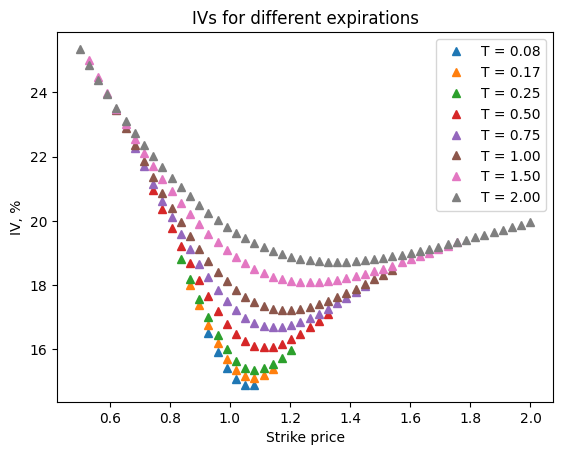

In [12]:
_, ax = plt.subplots()

for call, iv in zip(calls, ivs):
    ax.plot(
        call.strike_price,
        100 * iv,
        "^",
        label=f"T = {call.expiration_time:.2f}",
    )
    
ax.set_title("IVs for different expirations")
ax.set_ylabel("IV, %")
ax.set_xlabel("Strike price")
ax.legend()

plt.show()

In [13]:
def calibrate_adc(
    x: FloatArray,
    w: FloatArray,
    m: float,
    sigma: float
) -> float:
    """Calibrates the raw parameters `a, d, c` given `m, sigma`.

    This is an auxiliary function used in the two-step calibration
    procedure. It finds `a, d, c` which minimize the sum of squares of the
    differences of the given total implied variances and the ones produced
    by the model, assuming that `m, sigma` are given and fixed.

    Args:
      x: Array of log-moneynesses
      w: Array of total implied variances.
      m: Parameter `m` of the model.
      sigma: Parameter `sigma` of the model.

    Returns:
      Tuple `((a, d, c), f)` where `a, d, c` are the calibrated parameters
      and `f` is the value of the objective function at the minimum.
    """
    # Objective function; p = (a, d, c)
    def f(p):
        return 0.5*np.linalg.norm(
            p[0] + p[1]*(x-m)/sigma + p[2]*np.sqrt(((x-m)/sigma)**2+1) -
            w)**2

    # Gradient of the objective function
    def fprime(p):
        v1 = (x-m)/sigma
        v2 = np.sqrt(((x-m)/sigma)**2+1)
        v = p[0] + p[1]*v1 + p[2]*v2 - w
        return (np.sum(v), np.dot(v1, v), np.dot(v2, v))

    res = optimize.minimize(
        f,
        x0=(np.max(w)/2, 0, 2*sigma),
        method="SLSQP",
        jac=fprime,
        bounds=[(None, np.max(w)), (None, None), (0, 4*sigma)],
        constraints=[
            {'type': 'ineq',
             'fun': lambda p: p[2]-p[1],
             'jac': lambda _: (0, -1, 1)},
            {'type': 'ineq',
             'fun': lambda p: p[2]+p[1],
             'jac': lambda _: (0, 1, 1)},
            {'type': 'ineq',
             'fun': lambda p: 4*sigma - p[2]-p[1],
             'jac': lambda _: (0, -1, -1)},
            {'type': 'ineq',
             'fun': lambda p: p[1]+4*sigma-p[2],
             'jac': lambda _: (0, 1, -1)}])
    return res.x, res.fun

In [32]:
def fit_svi(
    option: StockOption,
    ms: MarketState,
    iv: FloatArray,
    min_sigma: float = 1e-4,
    max_sigma: float = 10,
    return_minimize_result: bool = False,
    seed: int = 0xB0BA11,  # 4 OK
) -> SVIParams:
    
    t_exp = option.expiration_time - ms.time
    f0 = ms.stock_price * np.exp(ms.interest_rate * t_exp)
    x = np.log(option.strike_price / f0)
    w = t_exp * iv**2 
    
    res = optimize.dual_annealing(
        lambda q: calibrate_adc(x, w, q[0], q[1])[1],  # q=(m, sigma)
        bounds=[(min(x) - 1e-3, max(x) + 1e-3), (min_sigma, max_sigma)],
        minimizer_kwargs={"method": "nelder-mead"},
        seed=seed,
    )
    m, sigma = res.x
    a, d, c = calibrate_adc(x, w, m, sigma)[0]
    rho = d/c
    b = c/sigma
    ret = SVIParams(a, b, rho, m, sigma)
    if return_minimize_result:
        return ret, res
    else:
        return ret

In [33]:
svis = []
for call, iv in zip(calls, ivs):
    for seed in (pbar := trange(100)):
        pbar.set_description_str(f"Trying seeds for tenor {call.expiration_time:.2f}")
        try:
            svi = fit_svi(call, ms, iv, seed=seed)
        except Exception:
            continue
        else:
            svis.append(svi)
            pbar.set_description_str(f"Tenor {call.expiration_time:.2f} calibration succeeded")
            break            
    else:
        svis.append(None)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

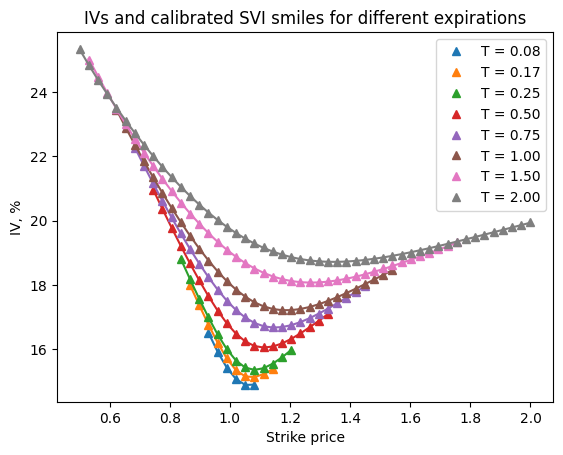

In [34]:
_, ax = plt.subplots()

for call, iv, svi in zip(calls, ivs, svis):
    t_exp = call.expiration_time - ms.time
    
    lines = ax.plot(
        call.strike_price,
        100 * iv,
        "^",
        label=f"T = {call.expiration_time:.2f}",
    )
    
    if svi is None:
        continue
    
    col = lines[0].get_color()
    f0 = ms.stock_price * np.exp(ms.interest_rate * t_exp)
    lm = np.log(call.strike_price / f0)
    svi_iv = np.sqrt(svi(lm) / t_exp)
    ax.plot(
        call.strike_price,
        100 * svi_iv,
        c=col,
    )
    
ax.set_title("IVs and calibrated SVI smiles for different expirations")
ax.set_ylabel("IV, %")
ax.set_xlabel("Strike price")
ax.legend()

plt.show()

In [35]:
print("Parameters in the raw parametrization:")
for call, svi in zip(calls, svis):
    if svi is None: continue
    print(f"T = {call.expiration_time:.2f}:", end="\t")
    for p in astuple(svi):
        print(f"{p:.3e}", end="\t")
    print()

print("\nParameters in the jump-wings parametrization:")
for call, svi in zip(calls, svis):
    if svi is None: continue
    print(f"T = {call.expiration_time:.2f}:", end="\t")
    for p in svi.to_jumpwing(call.expiration_time - ms.time):
        print(f"{p:.3e}", end="\t")
    print()

Parameters in the raw parametrization:
T = 0.08:	6.209e-04	8.507e-03	9.350e-02	7.215e-02	1.443e-01	
T = 0.17:	3.234e-03	8.242e-03	-3.881e-01	2.742e-02	7.637e-02	
T = 0.25:	4.425e-03	1.421e-02	-2.524e-01	3.901e-02	1.072e-01	
T = 0.50:	9.230e-03	2.650e-02	-2.351e-01	4.886e-02	1.421e-01	
T = 0.75:	1.415e-02	3.734e-02	-2.239e-01	5.945e-02	1.844e-01	
T = 1.00:	1.916e-02	4.680e-02	-2.182e-01	7.040e-02	2.293e-01	
T = 1.50:	2.834e-02	6.358e-02	-2.015e-01	9.616e-02	3.319e-01	
T = 2.00:	4.462e-02	7.035e-02	-2.473e-01	1.012e-01	3.736e-01	

Parameters in the jump-wings parametrization:
T = 0.08:	2.323e-02	-3.418e-02	1.752e-01	2.114e-01	2.212e-02	
T = 0.17:	2.394e-02	-4.737e-02	1.811e-01	7.983e-02	2.289e-02	
T = 0.25:	2.474e-02	-5.367e-02	2.262e-01	1.350e-01	2.359e-02	
T = 0.50:	2.703e-02	-6.386e-02	2.815e-01	1.743e-01	2.578e-02	
T = 0.75:	2.917e-02	-6.700e-02	3.090e-01	1.959e-01	2.781e-02	
T = 1.00:	3.110e-02	-6.788e-02	3.232e-01	2.075e-01	2.963e-02	
T = 1.50:	3.436e-02	-6.718e-02	3.365e-01	2.236e